# Zinser data (calibrated)

In [1]:
import netCDF4 as nc4
import numpy as np

# load data
datafile = 'Zinser_calibrated_m26.nc'

data_gridded = {}
with nc4.Dataset(datafile) as nc:
    for var in nc.variables:
        data_gridded[var] = nc.variables[var][:]

In [2]:
v_min = data_gridded['v_min']
delta_v = 1.0/data_gridded['delta_v_inv']
v = v_min * 2**(np.arange(data_gridded['m'])*delta_v) 

In [3]:
# prepare data for Stan model

dt = 15 # in units of minutes

data = {'dt':dt}
for k in ('m','v_min','delta_v_inv'):
    data[k] = data_gridded[k]

data['obs'] = data_gridded['w_obs']
data['t_obs'] = data_gridded['time']
data['E'] = data_gridded['PAR']
# use first measurements as initial conditions
data['w_ini'] = data_gridded['w_obs'][:,0]

# limit the data

limit_days = 2
stride_t_obs = 1 # keep everything

if limit_days > 0:
    limit_minutes = limit_days*1440
    
    ind_obs = data['t_obs'] < limit_minutes
    data['t_obs'] = data['t_obs'][ind_obs]
    data['obs'] = data['obs'][:,ind_obs]

    data['nt'] = int(limit_minutes//data['dt'])
    
if stride_t_obs > 0:
    data['t_obs'] = data['t_obs'][::stride_t_obs]
    data['obs'] = data['obs'][:,::stride_t_obs]

data['nt_obs'] = data['obs'].shape[1]

# finally, add light data
t = np.arange(data['nt'])*data['dt']
data['E'] = np.interp(t, xp=data_gridded['time'], fp=data_gridded['PAR'])

In [4]:
# data['i_test'] = [0,0,1,0,0,1,0,0,1,0,0,1] # one day
data['i_test'] = [0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1] # two days

# SeaFlow data

In [5]:
import sys

# load data
datafile_seaflow = '../data/SeaFlow_SizeDist_regrid-25-8.nc'

data_raw = {}
with nc4.Dataset(datafile_seaflow) as nc:
    for var in nc.variables:
        data_raw[var] = nc.variables[var][:]

In [6]:
v_min_seaflow = data_raw['v_min']
delta_v_seaflow = 1.0/data_raw['delta_v_inv']
v_seaflow = v_min_seaflow * 2**(np.arange(data_raw['m'])*delta_v_seaflow) 

In [7]:
# prepare data for Stan model

dt_seaflow = 20 # in units of minutes

data_seaflow = {'dt':dt_seaflow}
for k in ('m','v_min','delta_v_inv'):
    data_seaflow[k] = data_raw[k]

data_seaflow['obs'] = data_raw['w_obs']
data_seaflow['t_obs'] = data_raw['time']
data_seaflow['E'] = data_raw['PAR']
# use first measurements as initial conditions
data_seaflow['w_ini'] = data_raw['w_obs'][:,0]

# limit the data

limit_days_seaflow = 1
stride_t_obs_seaflow = dt_seaflow # keep everything

if limit_days_seaflow > 0:
    limit_minutes_seaflow = limit_days_seaflow*1440
    
    ind_obs_seaflow = data_seaflow['t_obs'] < limit_minutes_seaflow
    data_seaflow['t_obs'] = data_seaflow['t_obs'][ind_obs_seaflow]
    data_seaflow['obs'] = data_seaflow['obs'][:,ind_obs_seaflow]

    data_seaflow['nt'] = int(limit_minutes_seaflow//data_seaflow['dt'])
    
if stride_t_obs_seaflow > 0:
    data_seaflow['t_obs'] = data_seaflow['t_obs'][::stride_t_obs_seaflow]
    data_seaflow['obs'] = data_seaflow['obs'][:,::stride_t_obs_seaflow]

data_seaflow['nt_obs'] = data_seaflow['obs'].shape[1]

# finally, add light data
t = np.arange(data_seaflow['nt'])*data_seaflow['dt']
data_seaflow['E'] = np.interp(t, xp=data_raw['time'], fp=data_raw['PAR'])

In [8]:
data_seaflow['i_test'] = [0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1]

# The model - Zinser

modified from *Sosik et al. (2003), Growth rates of coastal phytoplankton from time-series measurements with a submersible flow cytometer, Limnol. Oceanogr.*

In [9]:
stan_code = '''data {
    // size variables
    int<lower=0> m;         // number of size classes
    int<lower=0> nt;        // number of timesteps
    int<lower=0> nt_obs;    // number of timesteps with observations
    
    // model parameters and input
    int<lower=0> dt;        // delta t in minutes
    real<lower=0> E[nt];    // vector of incident radiation values
    real<lower=0> v_min;    // size in smallest size class in um^-3
    int<lower=0> delta_v_inv;  // inverse of delta_v 
    
    // observations
    real<lower=0,upper=nt*dt>  t_obs[nt_obs]; // the time of each observation
    matrix[m, nt_obs] obs; //observations
    
    // validation
    int<lower=0,upper=1> i_test[nt_obs];
}
transformed data {
    int j;
    int min_obs = 0;
    int max_obs = 0;
    int temp = 1;
    real<lower=0> delta_v;
    real<lower=0> dt_days;  // dt in units of days
    real<lower=0> dt_norm;  // dt in units of days and doublings
    real<lower=0> v[m+1];   // vector of (minimum) sizes for each size class
    int<lower=0> t[nt];     // vector of times in minutes since start 
    int<lower=1, upper=nt> it_obs[nt_obs]; // the time index of each observation
    
    real thresh = 1e-4;
    matrix[m, nt_obs] new_obs; // observations with zeroes adjusted for log ratio transformation
    vector[nt_obs] count_obs = rep_vector(0.0, nt_obs);
    vector[nt_obs] geomeans_obs = rep_vector(0.0, nt_obs);
    
    int<lower=0> n_test;
	n_test = sum(i_test);
    
    // find smallest and largest size classes for which data exists
    while(temp < m && (min_obs == 0 || max_obs == 0)){
        if(max(obs[temp,]) > 0 && min_obs == 0){
            min_obs = temp;
        }
        if(max(obs[m+1-temp,]) > 0 && max_obs == 0){
            max_obs = m+1-temp;
        }
        temp += 1;
    }
    
    // adjust dataset for zeroes and calculate geometric means for use later
    for (it in 1:nt_obs){
        new_obs[, it] = rep_vector(0.0, m);
        for (iv in min_obs:max_obs){
            if (obs[iv, it] == 0){
                new_obs[iv, it] = thresh;
                count_obs[it] += 1;
            }
        }
    }
    
    for (it in 1:nt_obs){
        for (iv in min_obs:max_obs){
            if (obs[iv, it] != 0){
                new_obs[iv, it] = obs[iv, it] * (1 - count_obs[it]*thresh);
            }
        }
        geomeans_obs[it] = exp(mean(log(new_obs[min_obs:max_obs, it])));
    }

    j = 1 + delta_v_inv; 
    delta_v = 1.0/delta_v_inv;
    dt_days = dt/1440.0;
    dt_norm = dt/(1440.0 * (2^delta_v - 1.0));
    for (i in 1:m+1){
        v[i] = v_min*2^((i-1)*delta_v);
    }
    // populate time vector
    t[1] = 0;
    for (i in 2:nt){
        t[i] = (t[i-1] + dt);
    }
    // populate index vector it_obs
    for (k in 1:nt_obs){
        for (i in 1:nt){
            if (t_obs[k]>=t[i] && t_obs[k]<t[i]+dt){
                it_obs[k] = i;
                break;
            }
        }
    }
}
parameters {
    real<lower=0> delta_mu; 
    real<lower=0> delta_sigma; 
    real<lower=0, upper=1.0/dt_days> delta[m-(j-1)-(min_obs-1)-(m-max_obs)]; 
    real<lower=0> gamma_mu; 
    real<lower=0> gamma_sigma;
    real<lower=0, upper=1.0/dt_norm> gamma_max;
    real<lower=0, upper=5000> E_star; 
    real<lower=1e-10> sigma;
    real<lower=0> rho_mu;
    real<lower=0> rho_sigma;
    real<lower=0, upper=0.5*gamma_max> rho;
    real w_ini_mu;
    real<lower=1e-10> w_ini_sigma;
}
transformed parameters {
    real divrate;
    vector<lower=0>[m] w_ini;
    matrix[m,nt_obs] mod_obspos;
    {
        // helper variables
        vector[m] w_curr;
        vector[m] w_next;
        real delta_i = 0.0;
        real gamma;
        real a;
        real tmp;
        int ito = 1;
        int resp;
        real x;
       
        for (i in 1:m){
            if (i < min_obs || i > max_obs){
                w_ini[i] = 0.0;
            } else{
                x = 0.5*(log(v[i])+log(v[i+1]));
                w_ini[i] = 1/(sqrt(2*pi())*w_ini_sigma)*exp(-(x-w_ini_mu)^2/(2*w_ini_sigma^2));
            }
        }
        w_ini = w_ini/sum(w_ini);
        
        w_curr = w_ini;

        for (it in 1:nt){ // time-stepping loop
            // record current solution 
            if (it == it_obs[ito]){
                mod_obspos[,ito] = w_curr;
                ito += 1;
                if (ito > nt_obs){
                    break;
                }
            }
            
            w_next = rep_vector(0.0, m);
            
            // compute gamma
            gamma = gamma_max * dt_norm * (1.0 - exp(-E[it]/E_star)) - rho * dt_norm;
            if (gamma < 0){
                resp = 1;
                gamma = -gamma;
            } else{
                resp = 0;
            }
            
            for (i in min_obs:max_obs){ // size-class loop
                
                // compute delta_i
                if (i >= j+min_obs-1){
                    delta_i = delta[i-(j+min_obs-1)+1] * dt_days;
                }
                a = gamma * (1.0 - delta_i);
                
                // fill subdiagonal (growth)
                if(i < max_obs && resp == 0){
                    w_next[i+1] += a * w_curr[i];
                }
                
                // fill the 1st superdiagonal (respiration)
                if (i > 1 && resp == 1){
                    w_next[i-1] += a * w_curr[i];
                }
                
                // fill (j-1)th superdiagonal (division)
                a = 2.0*delta_i;
                
                if (i >= j+min_obs-1){
                    w_next[i+1-j] += a * w_curr[i];
                }
                
                // fill diagonal (stasis)
                if (i == min_obs && resp == 1){
                    a = 1;
                } else if (i == max_obs && resp == 0){
                    a = 1.0 - delta_i;
                } else if (i < j+min_obs-1){
                    a = (1.0-gamma);
                } else {
                    a = (1.0-gamma) * (1.0-delta_i);
                }
                w_next[i] += a * w_curr[i];
            }
            w_curr = w_next;
        }
        divrate = log(sum(w_curr))*60*24/(nt*dt); // daily division rate
    }
}
model {
    real diff;
    vector[nt_obs] popsums = rep_vector(0.0, nt_obs);
    matrix[m, nt_obs] comp;
    vector[nt_obs] geomeans = rep_vector(0.0, nt_obs);
    vector[nt_obs] count = rep_vector(0, nt_obs);
    
    // priors
    delta_mu ~ normal(0.05/dt_days, 5.0);
    delta_sigma ~ exponential(1.0);
    delta ~ normal(delta_mu, delta_sigma);
    gamma_mu ~ normal(0.05/dt_norm, 2.0);
    gamma_sigma ~ exponential(1.0);
    gamma_max ~ normal(gamma_mu, gamma_sigma);
    E_star ~ normal(300.0,100.0);
    rho_mu ~ normal(0.05/dt_norm, 2.0);
    rho_sigma ~ exponential(1.0);
    rho ~ normal(rho_mu, rho_sigma);
    
    sigma ~ exponential(1000.0);
    
    w_ini_mu ~ normal(-3.0, 1.0);
    w_ini_sigma ~ uniform(0.03, 3.0);
    
    // fitting observations via clr
    for (it in 1:nt_obs){
        if (i_test[it] == 0){
            popsums[it] = sum(mod_obspos[, it]);
            comp[, it] = rep_vector(0.0, m);
            for (iv in min_obs:max_obs){
                if (mod_obspos[iv, it] == 0){
                    comp[iv, it] = thresh;
                    count[it] += 1;
                } else{
                    comp[iv, it] = mod_obspos[iv, it] / popsums[it];
                }
            }
            
            for (iv in min_obs:max_obs){
                if (mod_obspos[iv, it] != 0){
                    comp[iv, it] *= (1 - count[it] * thresh);
                }
            }
            geomeans[it] = exp(mean(log(comp[min_obs:max_obs, it])));

            for (iv in min_obs:max_obs-1){
                diff = (log(comp[iv, it]) - log(geomeans[it]) - log(new_obs[iv, it]) + log(geomeans_obs[it])) / sigma;
                diff ~ normal(0.0, 1.0);
            }
        }
        
    }
    
}
generated quantities{
	real log_like_test = 0; 
    real log_like_train = 0;
	{real diff_test;
     real diff_train;
     
    vector[nt_obs] popsums = rep_vector(0.0, nt_obs);
    matrix[m, nt_obs] comp;
    vector[nt_obs] geomeans = rep_vector(0.0, nt_obs);
    vector[nt_obs] count = rep_vector(0, nt_obs);
     
	for(it in 1:nt_obs){
    
        popsums[it] = sum(mod_obspos[, it]);
        comp[, it] = rep_vector(0.0, m);

        for (iv in min_obs:max_obs){
            if (mod_obspos[iv, it] == 0){
                comp[iv, it] = thresh;
                count[it] += 1;
            } else{
                comp[iv, it] = mod_obspos[iv, it] / popsums[it];
            }
        }
        
        for (iv in min_obs:max_obs){
            if (mod_obspos[iv, it] != 0){
                comp[iv, it] *= (1 - count[it] * thresh);
            }
        }
        geomeans[it] = exp(mean(log(comp[min_obs:max_obs, it])));
        
		if(i_test[it] == 1){
			for(iv in min_obs:max_obs-1){
                diff_test = (log(comp[iv, it]) - log(geomeans[it]) - log(new_obs[iv, it]) + log(geomeans_obs[it])) / sigma;
                log_like_test += normal_lpdf(diff_test | 0.0, 1.0);
			}
		} else{
            for(iv in min_obs:max_obs-1){
                diff_train = (log(comp[iv, it]) - log(geomeans[it]) - log(new_obs[iv, it]) + log(geomeans_obs[it])) / sigma;
                log_like_train += normal_lpdf(diff_train |0.0, 1.0);
            }
        }
	}
	log_like_test  = log_like_test/(n_test*(max_obs-min_obs));
    log_like_train = log_like_train/((nt_obs-n_test)*(max_obs-min_obs));
	}
}
'''

In [10]:
import pystan

model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1b2fba72404d689cd96f97254347bc19 NOW.


In [11]:
mcmc = model.sampling(data=data, iter=2000)
print('\n'.join(x for x in mcmc.__str__().split('\n') if 'mod_obspos' not in x))

Inference for Stan model: anon_model_1b2fba72404d689cd96f97254347bc19.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_mu            1.28  8.1e-3   0.42   0.45   1.01   1.28   1.56   2.14   2683    1.0
delta_sigma         1.82  5.5e-3   0.32   1.31    1.6   1.78    2.0   2.56   3343    1.0
delta[1]            0.95  2.6e-3   0.14    0.7   0.86   0.94   1.04   1.26   2889    1.0
delta[2]            0.29  2.4e-3   0.12   0.05    0.2   0.28   0.37   0.55   2587    1.0
delta[3]            0.19  1.9e-3   0.11   0.02   0.11   0.18   0.26   0.41   3044    1.0
delta[4]            0.19  1.9e-3    0.1   0.02   0.11   0.18   0.25   0.41   2927    1.0
delta[5]            0.16  1.7e-3    0.1   0.01   0.09   0.15   0.22   0.37   2964    1.0
delta[6]            0.29  1.9e-3   0.11   0.09   0.21   0.28   0.36   0.52   3115    1.0
delta[7]  

# The model - SeaFlow

modified from *Sosik et al. (2003), Growth rates of coastal phytoplankton from time-series measurements with a submersible flow cytometer, Limnol. Oceanogr.*

In [12]:
stan_code_seaflow = '''data {
    // size variables
    int<lower=0> m;         // number of size classes
    int<lower=0> nt;        // number of timesteps
    int<lower=0> nt_obs;    // number of timesteps with observations
    
    // model parameters and input
    int<lower=0> dt;        // delta t in minutes
    real<lower=0> E[nt];    // vector of incident radiation values
    real<lower=0> v_min;    // size in smallest size class in um^-3
    int<lower=0> delta_v_inv;  // inverse of delta_v 
    
    // observations
    real<lower=0,upper=nt*dt>  t_obs[nt_obs]; // the time of each observation
    matrix[m, nt_obs] obs; //observations
    
    // validation
    int<lower=0,upper=1> i_test[nt_obs];
}
transformed data {
    int j;
    int min_obs = 0;
    int max_obs = 0;
    int temp = 1;
    real<lower=0> delta_v;
    real<lower=0> dt_days;  // dt in units of days
    real<lower=0> dt_norm;  // dt in units of days and doublings
    real<lower=0> v[m+1];   // vector of (minimum) sizes for each size class
    int<lower=0> t[nt];     // vector of times in minutes since start 
    int<lower=1, upper=nt> it_obs[nt_obs]; // the time index of each observation
    
    real thresh = 1e-6;
    matrix[m, nt_obs] new_obs; // observations with zeroes adjusted for log ratio transformation
    vector[nt_obs] count_obs = rep_vector(0.0, nt_obs);
    vector[nt_obs] geomeans_obs = rep_vector(0.0, nt_obs);
    
    int<lower=0> n_test;
	n_test = sum(i_test);
    
    // find smallest and largest size classes for which data exists
    while(temp < m && (min_obs == 0 || max_obs == 0)){
        if(max(obs[temp,]) > 0 && min_obs == 0){
            min_obs = temp;
        }
        if(max(obs[m+1-temp,]) > 0 && max_obs == 0){
            max_obs = m+1-temp;
        }
        temp += 1;
    }
    
    // adjust dataset for zeroes and calculate geometric means for use later
    for (it in 1:nt_obs){
        new_obs[, it] = rep_vector(0.0, m);
        for (iv in min_obs:max_obs){
            if (obs[iv, it] == 0){
                new_obs[iv, it] = thresh;
                count_obs[it] += 1;
            }
        }
    }
    
    for (it in 1:nt_obs){
        for (iv in min_obs:max_obs){
            if (obs[iv, it] != 0){
                new_obs[iv, it] = obs[iv, it] * (1 - count_obs[it]*thresh);
            }
        }
        geomeans_obs[it] = exp(mean(log(new_obs[min_obs:max_obs, it])));
    }

    j = 1 + delta_v_inv; 
    delta_v = 1.0/delta_v_inv;
    dt_days = dt/1440.0;
    dt_norm = dt/(1440.0 * (2^delta_v - 1.0));
    for (i in 1:m+1){
        v[i] = v_min*2^((i-1)*delta_v);
    }
    // populate time vector
    t[1] = 0;
    for (i in 2:nt){
        t[i] = (t[i-1] + dt);
    }
    // populate index vector it_obs
    for (k in 1:nt_obs){
        for (i in 1:nt){
            if (t_obs[k]>=t[i] && t_obs[k]<t[i]+dt){
                it_obs[k] = i;
                break;
            }
        }
    }
}
parameters {
    real<lower=0> delta_mu; 
    real<lower=0> delta_sigma; 
    real<lower=0, upper=1.0/dt_days> delta[m-(j-1)-(min_obs-1)-(m-max_obs)]; 
    real<lower=0> gamma_mu; 
    real<lower=0> gamma_sigma;
    real<lower=0, upper=1.0/dt_norm> gamma_max;
    real<lower=0, upper=5000> E_star; 
    real<lower=1e-10> sigma;
    real<lower=0> rho_mu;
    real<lower=0> rho_sigma;
    real<lower=0, upper=0.5*gamma_max> rho;
    real w_ini_mu;
    real<lower=1e-10> w_ini_sigma;
}
transformed parameters {
    real divrate;
    vector<lower=0>[m] w_ini;
    matrix[m,nt_obs] mod_obspos;
    {
        // helper variables
        vector[m] w_curr;
        vector[m] w_next;
        real delta_i = 0.0;
        real gamma;
        real a;
        real tmp;
        int ito = 1;
        int resp;
        real x;
       
        for (i in 1:m){
            if (i < min_obs || i > max_obs){
                w_ini[i] = 0.0;
            } else{
                x = 0.5*(log(v[i])+log(v[i+1]));
                w_ini[i] = 1/(sqrt(2*pi())*w_ini_sigma)*exp(-(x-w_ini_mu)^2/(2*w_ini_sigma^2));
            }
        }
        w_ini = w_ini/sum(w_ini);
        
        w_curr = w_ini;

        for (it in 1:nt){ // time-stepping loop
            // record current solution 
            if (it == it_obs[ito]){
                mod_obspos[,ito] = w_curr;
                ito += 1;
                if (ito > nt_obs){
                    break;
                }
            }
            
            w_next = rep_vector(0.0, m);
            
            // compute gamma
            gamma = gamma_max * dt_norm * (1.0 - exp(-E[it]/E_star)) - rho * dt_norm;
            if (gamma < 0){
                resp = 1;
                gamma = -gamma;
            } else{
                resp = 0;
            }
            
            for (i in min_obs:max_obs){ // size-class loop
                
                // compute delta_i
                if (i >= j+min_obs-1){
                    delta_i = delta[i-(j+min_obs-1)+1] * dt_days;
                }
                a = gamma * (1.0 - delta_i);
                
                // fill subdiagonal (growth)
                if(i < max_obs && resp == 0){
                    w_next[i+1] += a * w_curr[i];
                }
                
                // fill the 1st superdiagonal (respiration)
                if (i > 1 && resp == 1){
                    w_next[i-1] += a * w_curr[i];
                }
                
                // fill (j-1)th superdiagonal (division)
                a = 2.0*delta_i;
                
                if (i >= j+min_obs-1){
                    w_next[i+1-j] += a * w_curr[i];
                }
                
                // fill diagonal (stasis)
                if (i == min_obs && resp == 1){
                    a = 1;
                } else if (i == max_obs && resp == 0){
                    a = 1.0 - delta_i;
                } else if (i < j+min_obs-1){
                    a = (1.0-gamma);
                } else {
                    a = (1.0-gamma) * (1.0-delta_i);
                }
                w_next[i] += a * w_curr[i];
            }
            w_curr = w_next;
        }
        divrate = log(sum(w_curr))*60*24/(nt*dt); // daily division rate
    }
}
model {
    real diff;
    vector[nt_obs] popsums = rep_vector(0.0, nt_obs);
    matrix[m, nt_obs] comp;
    vector[nt_obs] geomeans = rep_vector(0.0, nt_obs);
    vector[nt_obs] count = rep_vector(0, nt_obs);
    
    // priors
    delta_mu ~ normal(5.0, 1.0);
    delta_sigma ~ exponential(0.1);
    delta ~ normal(delta_mu, delta_sigma);
    gamma_mu ~ normal(5.0, 2.0);
    gamma_sigma ~ exponential(1.0);
    gamma_max ~ normal(gamma_mu, gamma_sigma);
    E_star ~ normal(300.0,100.0);
    rho_mu ~ normal(2.0, 2.0);
    rho_sigma ~ exponential(1.0);
    rho ~ normal(rho_mu, rho_sigma);
    
    sigma ~ exponential(1000.0);
    
    w_ini_mu ~ normal(-4.0, 1.0);
    w_ini_sigma ~ uniform(0.03, 3.0);
    
    // fitting observations via clr
    for (it in 1:nt_obs){
        if (i_test[it] == 0){
            popsums[it] = sum(mod_obspos[, it]);
            comp[, it] = rep_vector(0.0, m);
            for (iv in min_obs:max_obs){
                if (mod_obspos[iv, it] == 0){
                    comp[iv, it] = thresh;
                    count[it] += 1;
                } else{
                    comp[iv, it] = mod_obspos[iv, it] / popsums[it];
                }
            }
            
            for (iv in min_obs:max_obs){
                if (mod_obspos[iv, it] != 0){
                    comp[iv, it] *= (1 - count[it] * thresh);
                }
            }
            geomeans[it] = exp(mean(log(comp[min_obs:max_obs, it])));

            for (iv in min_obs:max_obs-1){
                diff = (log(comp[iv, it]) - log(geomeans[it]) - log(new_obs[iv, it]) + log(geomeans_obs[it])) / sigma;
                diff ~ normal(0.0, 1.0);
            }
        }
        
    }
    
}
generated quantities{
	real log_like_test = 0; 
    real log_like_train = 0;
	{real diff_test;
     real diff_train;
     
    vector[nt_obs] popsums = rep_vector(0.0, nt_obs);
    matrix[m, nt_obs] comp;
    vector[nt_obs] geomeans = rep_vector(0.0, nt_obs);
    vector[nt_obs] count = rep_vector(0, nt_obs);
     
	for(it in 1:nt_obs){
    
        popsums[it] = sum(mod_obspos[, it]);
        comp[, it] = rep_vector(0.0, m);

        for (iv in min_obs:max_obs){
            if (mod_obspos[iv, it] == 0){
                comp[iv, it] = thresh;
                count[it] += 1;
            } else{
                comp[iv, it] = mod_obspos[iv, it] / popsums[it];
            }
        }
        
        for (iv in min_obs:max_obs){
            if (mod_obspos[iv, it] != 0){
                comp[iv, it] *= (1 - count[it] * thresh);
            }
        }
        geomeans[it] = exp(mean(log(comp[min_obs:max_obs, it])));
        
		if(i_test[it] == 1){
			for(iv in min_obs:max_obs-1){
                diff_test = (log(comp[iv, it]) - log(geomeans[it]) - log(new_obs[iv, it]) + log(geomeans_obs[it])) / sigma;
                log_like_test += normal_lpdf(diff_test | 0.0, 1.0);
			}
		} else{
            for(iv in min_obs:max_obs-1){
                diff_train = (log(comp[iv, it]) - log(geomeans[it]) - log(new_obs[iv, it]) + log(geomeans_obs[it])) / sigma;
                log_like_train += normal_lpdf(diff_train |0.0, 1.0);
            }
        }
	}
	log_like_test  = log_like_test/(n_test*(max_obs-min_obs));
    log_like_train = log_like_train/((nt_obs-n_test)*(max_obs-min_obs));
	}
}
'''

In [13]:
import pystan

model_seaflow = pystan.StanModel(model_code=stan_code_seaflow)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fe43485de6b922c2e909ef7eca84721f NOW.


In [14]:
mcmc_seaflow = model_seaflow.sampling(data=data_seaflow, iter=2000)
print('\n'.join(x for x in mcmc_seaflow.__str__().split('\n') if 'mod_obspos' not in x))

Inference for Stan model: anon_model_fe43485de6b922c2e909ef7eca84721f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_mu            2.18    0.01   0.37   1.55   1.92   2.14    2.4    3.0   1116    1.0
delta_sigma         1.03  6.9e-3   0.31    0.6   0.82   0.97   1.17   1.75   1964    1.0
delta[1]            0.06  8.8e-4   0.03   0.01   0.04   0.06   0.08   0.11    887    1.0
delta[2]            0.76  3.6e-3   0.12   0.54   0.68   0.75   0.84   1.01   1071    1.0
delta[3]            0.91  3.0e-3   0.16   0.63    0.8    0.9    1.0   1.23   2756    1.0
delta[4]            1.48  5.0e-3   0.25   1.01   1.31   1.46   1.63   1.99   2430    1.0
delta[5]            2.09  6.0e-3   0.31   1.51   1.88   2.08    2.3    2.7   2611    1.0
delta[6]            2.49  7.4e-3   0.35   1.82   2.25   2.49   2.72   3.19   2190    1.0
delta[7]  

## Plot the results - Zinser

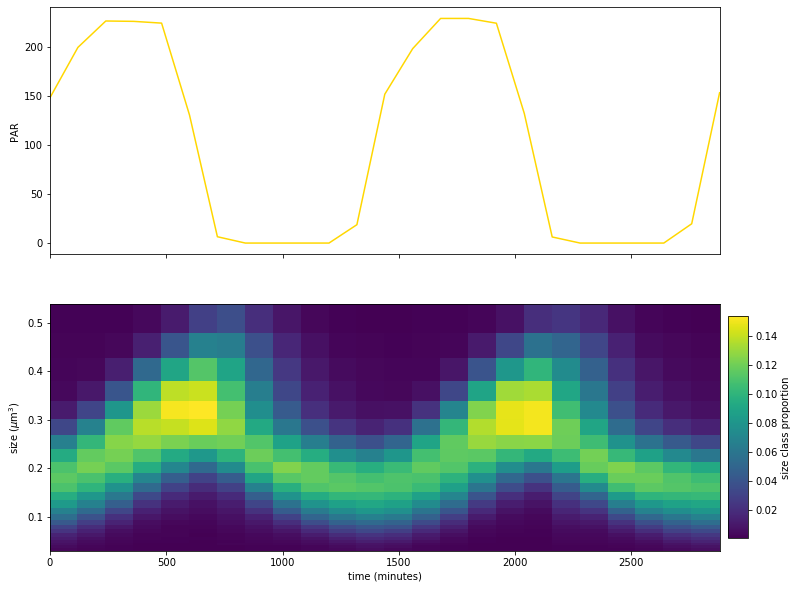

In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

fig,axs = plt.subplots(nrows=2, sharex=True, figsize=(12,10))

ax = axs[0]
ax.plot(data_gridded['time'], data_gridded['PAR'], color='gold')
ax.set(ylabel='PAR')

ax = axs[1]
pc = ax.pcolormesh(data_gridded['time'],v,data_gridded['w_obs'])
ax.set(ylabel='size ($\mu$m$^3$)', xlabel='time (minutes)')
add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
None

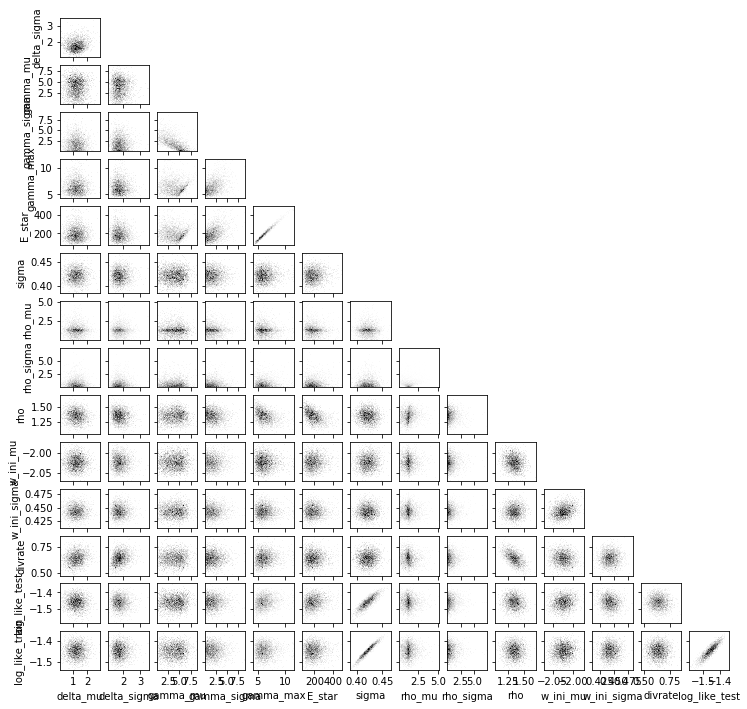

In [16]:
paramnames = [v for v in mcmc.flatnames if not v.startswith('mod_obspos') and not v.startswith('delta_max') and not '[' in v]
num_params = len(paramnames)

fig,axs = plt.subplots(num_params-1,num_params-1,sharex='col',sharey='row',figsize=(12,12), squeeze=False)
for ax in axs.flat:
    ax.set_visible(False)
for irow in range(1,num_params):
    for icol in range(irow):
        ax = axs[irow-1,icol]
        ax.set_visible(True)
        xname = paramnames[icol]
        yname = paramnames[irow]
        ax.hist2d(mcmc[xname],mcmc[yname],bins=50,cmap=mpl.cm.gray_r)
        if icol == 0:
            ax.set_ylabel(yname)
        if irow == num_params-1:
            ax.set_xlabel(xname)
None

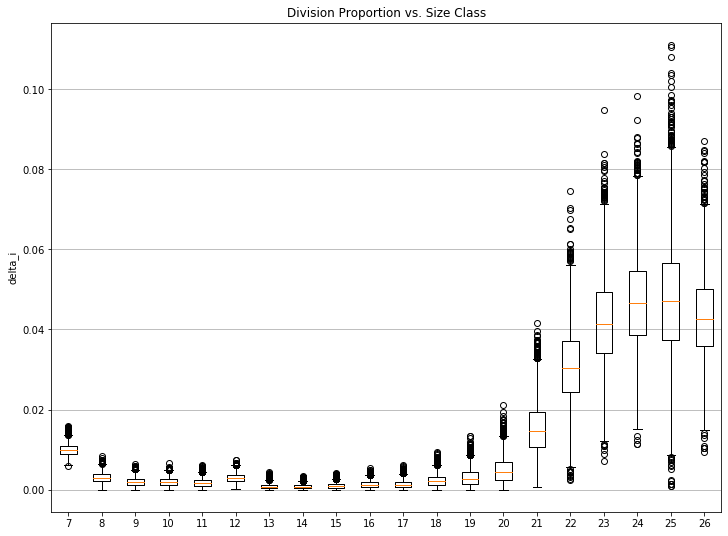

In [17]:
j = data_gridded['delta_v_inv'] + 1
m = data_gridded['m']

fig, axs = plt.subplots(nrows=1, sharex=True, figsize=(12,9))
ax = axs
ax.boxplot(mcmc['delta']*dt/1440, positions=range(j,m+1))
ax.set(ylabel='delta_i')
ax.yaxis.grid(True)
ax.title.set_text('Division Proportion vs. Size Class')

# ax = axs[1]
# ax.boxplot(mcmc['gamma_max']*dt/1440, positions=range(1,m))
# ax.set(ylabel='gamma_max')
# ax.yaxis.grid(True)

# ax = axs[2]
# ax.boxplot(mcmc['rho']*dt/1440, positions=range(1,m))
# ax.set(ylabel='rho')
# ax.yaxis.grid(True)

xlabels = [str(x) for x in range(1,m+1)]
None

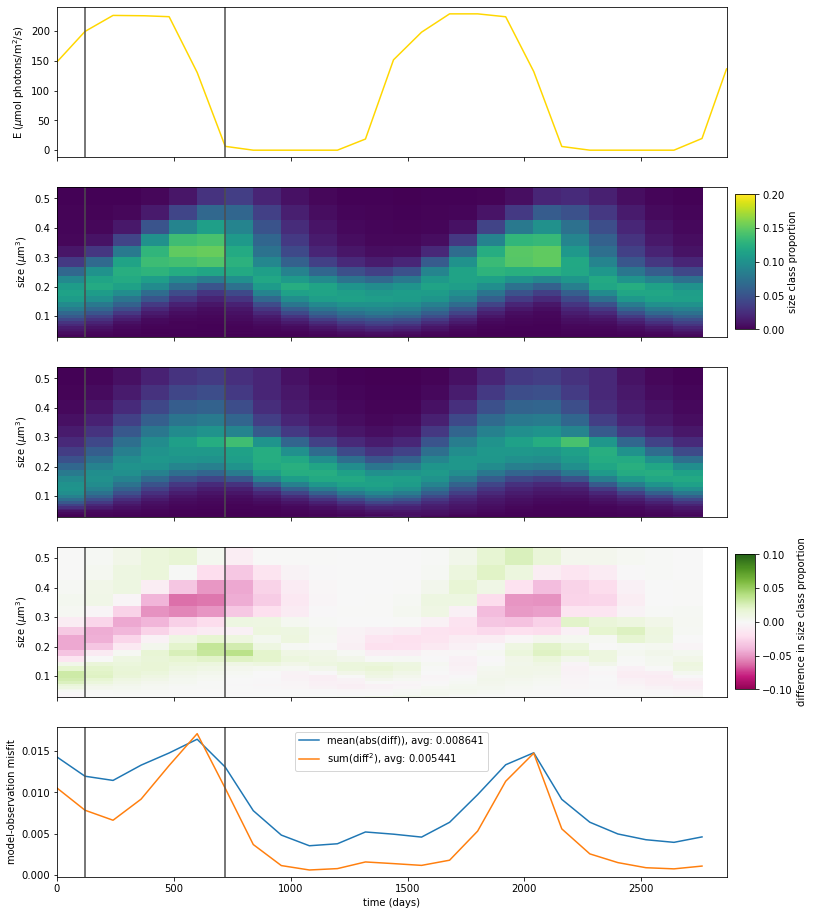

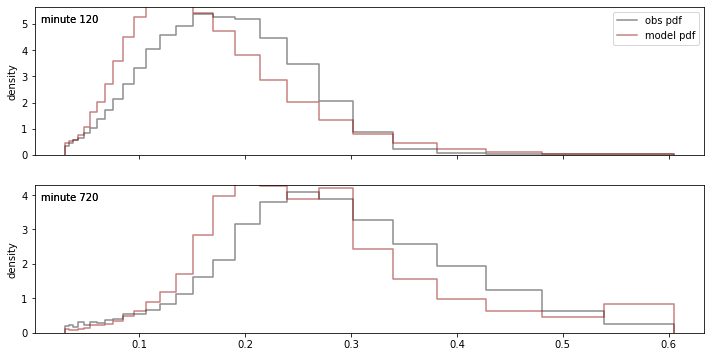

In [18]:
res = {'model':np.mean(mcmc['mod_obspos'], axis=0), 'obs':data['obs']}
colors = {'model':'darkred', 'obs':'0.1'}

res['model'] = res['model']/res['model'].sum(axis=0)
diff = res['model']-res['obs']

t = data['dt']*np.arange(data['nt'])
slice_indices = [1,6]
v_ext = data['v_min'] * 2**(np.arange(data['m']+1)*delta_v) 
v_width = v_ext[1:] - v_ext[:-1]

norm = mpl.colors.Normalize(0.0,0.2)
norm_diff = mpl.colors.Normalize(-0.1,0.1)

fig,axs = plt.subplots(5,1,sharex=True,figsize=(12,16))

ax = axs[0]
ax.plot(t, data['E'], color='gold')
ax.set(xlim=(data['t_obs'][0],t[-1]), ylabel='E ($\mu$mol photons/m$^{2}$/s)')

ax = axs[1]
pc = ax.pcolormesh(data['t_obs'],v,res['obs'],norm=norm)
ax.set(ylabel='size ($\mu$m$^3$)')
add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

ax = axs[2]
ax.set(ylabel='size ($\mu$m$^3$)')
pc = ax.pcolormesh(data['t_obs'],v,res['model'],norm=norm)

ax = axs[3]
pc = ax.pcolormesh(data['t_obs'],v,diff,norm=norm_diff, cmap='PiYG')
ax.set(ylabel='size ($\mu$m$^3$)')
add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='difference in size class proportion')

ax = axs[4]
prop = np.mean(np.abs(diff),axis=0)
ax.plot(data['t_obs'], prop, label='mean(abs(diff)), avg: {:.6f}'.format(np.mean(prop)))
prop = np.sum(diff**2,axis=0)
ax.plot(data['t_obs'], prop, label='sum(diff$^2$), avg: {:.6f}'.format(np.mean(prop)))
ax.set(xlabel='time (days)', ylabel='model-observation misfit')
ax.legend()

for ax in axs.flat:
    for i in slice_indices:
        ax.axvline(data['t_obs'][i], color='.3')

# plot slices

plotdata_y = np.zeros(2*(data['m']+1))

fig,axs = plt.subplots(nrows=len(slice_indices), sharex=True, figsize=(12,len(slice_indices)*3))
for i,ax in zip(slice_indices,axs.flat):
    for name in ('obs','model'):
        color = colors[name]
        cdata = res[name][:,i]
        plotdata_y[1:-1] = np.repeat(cdata/v_width,2)
        ax.plot(np.repeat(v_ext,2), plotdata_y, color=color, alpha=0.5, label='{} pdf'.format(name))
        ax.text(0.01, 0.95, 'minute {}'.format(data['t_obs'][i]), transform=ax.transAxes, va='top', ha='left')
        ax.set_ylabel('density')
        ax.set_ylim(bottom=0.0)
axs[0].legend()
None

## Plot the results - Seaflow

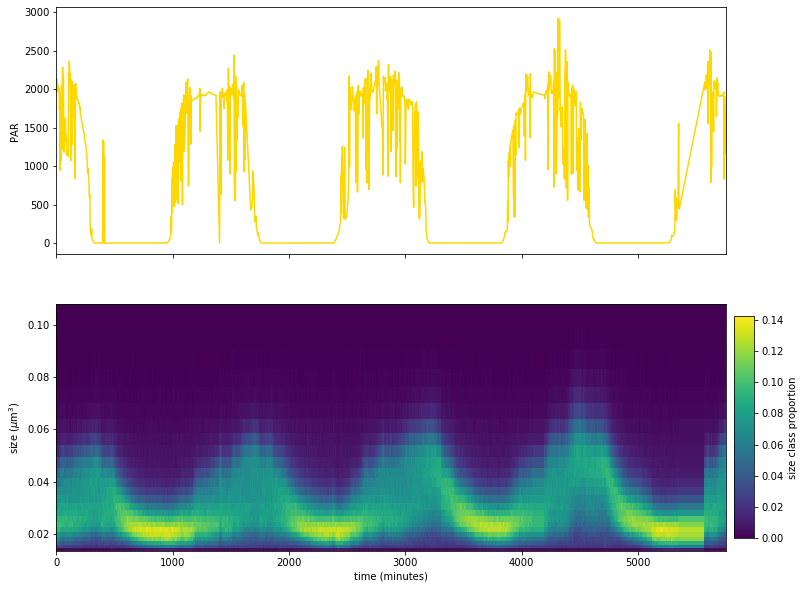

In [19]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

fig,axs = plt.subplots(nrows=2, sharex=True, figsize=(12,10))

ax = axs[0]
ax.plot(data_raw['time'], data_raw['PAR'], color='gold')
ax.set(ylabel='PAR')

ax = axs[1]
pc = ax.pcolormesh(data_raw['time'],v_seaflow,data_raw['w_obs'])
ax.set(ylabel='size ($\mu$m$^3$)', xlabel='time (minutes)')
add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
None

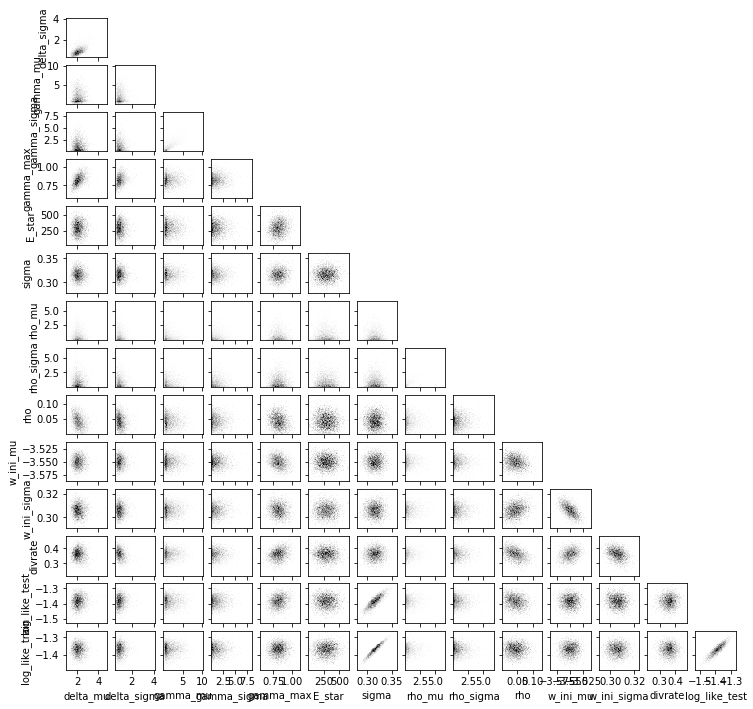

In [20]:
paramnames_seaflow = [v_seaflow for v_seaflow in mcmc_seaflow.flatnames if not v_seaflow.startswith('mod_obspos') and not v_seaflow.startswith('delta_max') and not '[' in v_seaflow]
num_params_seaflow = len(paramnames)

fig,axs = plt.subplots(num_params_seaflow-1,num_params_seaflow-1,sharex='col',sharey='row',figsize=(12,12), squeeze=False)
for ax in axs.flat:
    ax.set_visible(False)
for irow in range(1,num_params_seaflow):
    for icol in range(irow):
        ax = axs[irow-1,icol]
        ax.set_visible(True)
        xname = paramnames_seaflow[icol]
        yname = paramnames_seaflow[irow]
        ax.hist2d(mcmc_seaflow[xname],mcmc_seaflow[yname],bins=50,cmap=mpl.cm.gray_r)
        if icol == 0:
            ax.set_ylabel(yname)
        if irow == num_params-1:
            ax.set_xlabel(xname)
None

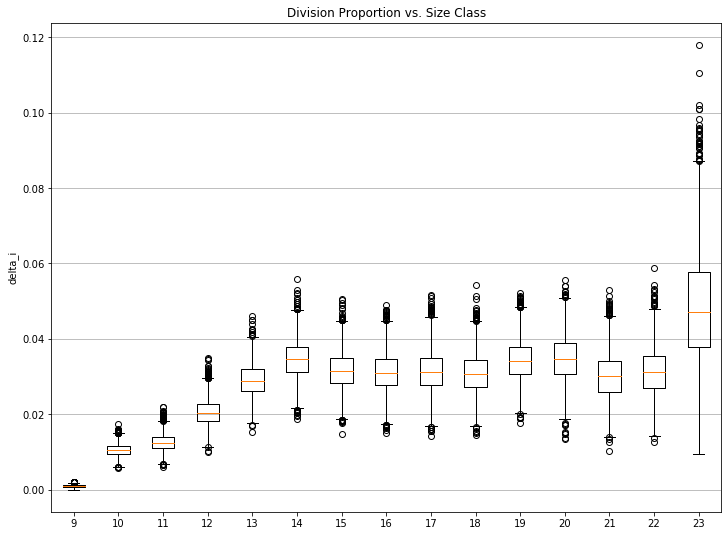

In [21]:
j = data_raw['delta_v_inv'] + 1
m = data_raw['m']

fig, axs = plt.subplots(nrows=1, sharex=True, figsize=(12,9))
ax = axs
ax.boxplot(mcmc_seaflow['delta']*dt_seaflow/1440, positions=range(j,m-1))
ax.set(ylabel='delta_i')
ax.yaxis.grid(True)
ax.title.set_text('Division Proportion vs. Size Class')

# ax = axs[1]
# ax.boxplot(mcmc['gamma_max']*dt/1440, positions=range(1,m))
# ax.set(ylabel='gamma_max')
# ax.yaxis.grid(True)

# ax = axs[2]
# ax.boxplot(mcmc['rho']*dt/1440, positions=range(1,m))
# ax.set(ylabel='rho')
# ax.yaxis.grid(True)

xlabels = [str(x) for x in range(1,m+1)]
None

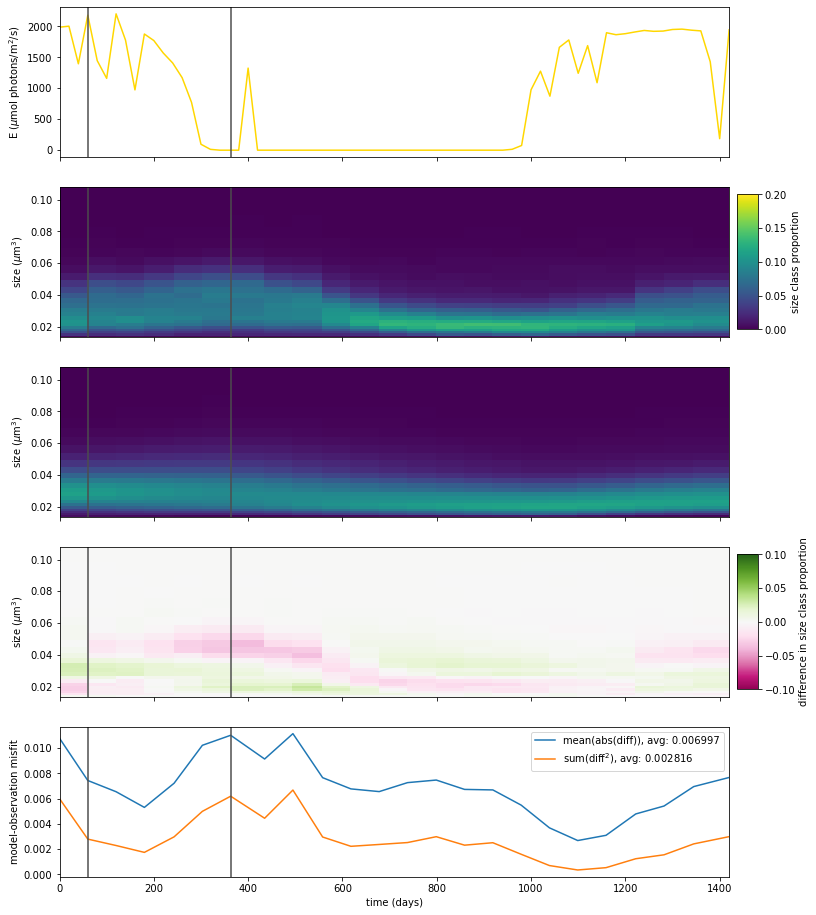

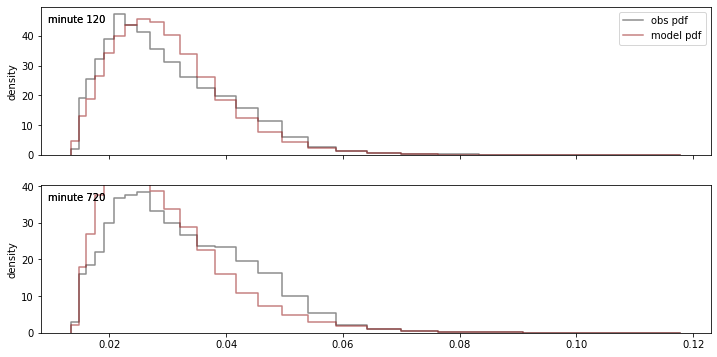

In [22]:
res_seaflow = {'model':np.mean(mcmc_seaflow['mod_obspos'], axis=0), 'obs':data_seaflow['obs']}
colors = {'model':'darkred', 'obs':'0.1'}

res_seaflow['model'] = res_seaflow['model']/res_seaflow['model'].sum(axis=0)
diff = res_seaflow['model']-res_seaflow['obs']

t = data_seaflow['dt']*np.arange(data_seaflow['nt'])
slice_indices = [1,6]
v_ext = data_seaflow['v_min'] * 2**(np.arange(data_seaflow['m']+1)*delta_v_seaflow) 
v_width = v_ext[1:] - v_ext[:-1]

norm = mpl.colors.Normalize(0.0,0.2)
norm_diff = mpl.colors.Normalize(-0.1,0.1)

fig,axs = plt.subplots(5,1,sharex=True,figsize=(12,16))

ax = axs[0]
ax.plot(t, data_seaflow['E'], color='gold')
ax.set(xlim=(data_seaflow['t_obs'][0],t[-1]), ylabel='E ($\mu$mol photons/m$^{2}$/s)')

ax = axs[1]
pc = ax.pcolormesh(data_seaflow['t_obs'],v_seaflow,res_seaflow['obs'],norm=norm)
ax.set(ylabel='size ($\mu$m$^3$)')
add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

ax = axs[2]
ax.set(ylabel='size ($\mu$m$^3$)')
pc = ax.pcolormesh(data_seaflow['t_obs'],v_seaflow,res_seaflow['model'],norm=norm)

ax = axs[3]
pc = ax.pcolormesh(data_seaflow['t_obs'],v_seaflow,diff,norm=norm_diff, cmap='PiYG')
ax.set(ylabel='size ($\mu$m$^3$)')
add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='difference in size class proportion')

ax = axs[4]
prop = np.mean(np.abs(diff),axis=0)
ax.plot(data_seaflow['t_obs'], prop, label='mean(abs(diff)), avg: {:.6f}'.format(np.mean(prop)))
prop = np.sum(diff**2,axis=0)
ax.plot(data_seaflow['t_obs'], prop, label='sum(diff$^2$), avg: {:.6f}'.format(np.mean(prop)))
ax.set(xlabel='time (days)', ylabel='model-observation misfit')
ax.legend()

for ax in axs.flat:
    for i in slice_indices:
        ax.axvline(data_seaflow['t_obs'][i], color='.3')

# plot slices

plotdata_y = np.zeros(2*(data_seaflow['m']+1))

fig,axs = plt.subplots(nrows=len(slice_indices), sharex=True, figsize=(12,len(slice_indices)*3))
for i,ax in zip(slice_indices,axs.flat):
    for name in ('obs','model'):
        color = colors[name]
        cdata = res_seaflow[name][:,i]
        plotdata_y[1:-1] = np.repeat(cdata/v_width,2)
        ax.plot(np.repeat(v_ext,2), plotdata_y, color=color, alpha=0.5, label='{} pdf'.format(name))
        ax.text(0.01, 0.95, 'minute {}'.format(data['t_obs'][i]), transform=ax.transAxes, va='top', ha='left')
        ax.set_ylabel('density')
        ax.set_ylim(bottom=0.0)
axs[0].legend()
None